### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score,precision_score,accuracy_score,recall_score,classification_report,confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold, RandomizedSearchCV,RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,LabelEncoder,Normalizer,MaxAbsScaler
from sklearn.decomposition import PCA
import random
#from imblearn.combine import SMOTEENN
from feature_engine.encoding import CountFrequencyEncoder,OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import pickle
from datetime import date
import datetime
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve




### Functions

In [19]:
def hist_group_by_exit(df,var):
    plt.figure(figsize=(16, 6))

    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    sns.histplot(df[df['Exited'] == 1][var], ax=ax1, color='salmon', alpha=0.7)
    sns.histplot(df[df['Exited'] == 0][var], ax=ax2, color='steelblue', alpha=0.7)

    ax1.set_title(f'Distribución de {var} en Clientes que Hicieron Churn')
    ax1.set_xlabel(var)
    ax1.set_ylabel('Cantidad')

    ax2.set_title(f'Distribución de {var} en Clientes Retenidos')
    ax2.set_xlabel(var)
    ax2.set_ylabel('Cantidad')

    ax1.legend(['Churned'], loc='upper right')
    ax2.legend(['Not churned'], loc='upper right')

    plt.tight_layout()

    plt.show()

def boxplot_by_exit(df,var):
    plt.figure(figsize=(16, 6))

    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    sns.boxplot(y=var,data=df[df['Exited'] == 1], ax=ax1, color='salmon')
    sns.boxplot(y=var,data=df[df['Exited'] == 0], ax=ax2, color='steelblue')

    ax1.set_title(f'Boxplot de {var} en Clientes que Hicieron Churn')
    ax1.set_xlabel(var)
    ax1.set_ylabel('Cantidad')

    ax2.set_title(f'Boxplot de {var} en Clientes Retenidos')
    ax2.set_xlabel(var)
    ax2.set_ylabel('Cantidad')

    ax1.legend(['Churned'], loc='upper right')
    ax2.legend(['Not churned'], loc='upper right')

    plt.tight_layout()

    plt.show()

def new_variables(df):
  df['CreditScore_x_Age']=df['CreditScore']/df['Age']
  df['CreditScore_x_Balance']=df['Balance']/df['CreditScore']
  df['NumOfProducts_x_Age']=df['NumOfProducts']/df['Age']
  df['Tenure_x_Age']=df.apply(lambda x: x['Tenure']/x['Age'] if x['Age']!=None else 0,axis=1)
  df['%SalaryInBank']=(df['Tenure']*df['Balance'])/df['EstimatedSalary']
  df['Balance_x_EstimatedSalary']=df['Balance']/df['EstimatedSalary']
  df['AgeofEntry']=df['Age']-df['Tenure']
  df['CustomerEngagement']=df.apply(lambda x:x['Age']*x['CreditScore']*x['NumOfProducts'],axis=1)
  df['EducationProduct']=df.apply(lambda x:x['Age']*x['EducationYears']*x['NumOfProducts'],axis=1)

  return df

def encoding(df):
  df=pd.get_dummies(data=df,columns=['Geography'])
  return df

def imputer(df,cat_imputer,num_imputer,train=True):
  cat=[]
  num=[]
  if 'Id' in df.columns:
    df=df.drop('Id',axis=1)
  else:
    pass
  if 'Exited' in df.columns:
    for col in df.drop('Exited',axis=1).columns:
      if df[col].dtype=='object':
        cat.append(col)
      else:
        num.append(col)
    if train==True:
      df[cat]=cat_imputer.fit_transform(df[cat])
      df[num]=num_imputer.fit_transform(df[num])
    else:
      df[cat]=cat_imputer.transform(df[cat])
      df[num]=num_imputer.transform(df[num])
    return df
  else:
    for col in df.columns:
      if df[col].dtype=='object':
        cat.append(col)
      else:
        num.append(col)
    if train==True:
      df[cat]=cat_imputer.fit_transform(df[cat])
      df[num]=num_imputer.fit_transform(df[num])
    else:
      df[cat]=cat_imputer.transform(df[cat])
      df[num]=num_imputer.transform(df[num])
    return df

def print_metrics(y_val, y_pred,clf,X_val,skf):
  precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
  pr_auc = auc(recall, precision)
  accuracy = accuracy_score(y_val, y_pred)
  precision=precision_score(y_val,y_pred)
  recall=recall_score(y_val,y_pred)
  f1=f1_score(y_val,y_pred)
  auc_score = roc_auc_score(y_val, y_pred)
  report = classification_report(y_val, y_pred)
  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-Score: {f1}")
  print(f"AUC-Score: {auc_score}")
  print(f"PRAUC: {pr_auc:.4f}")
  print(f"Cross-Validation Accuracy: {cross_val_score(clf,X_val,y_val,cv=skf,scoring='accuracy').mean()}")
  print(f"Classification Report:\n{report}")


  

def plot_confusion_matrix(y_true, y_pred):
  sns.heatmap(confusion_matrix(y_true, y_pred),
              annot=True,
              fmt='g',
              xticklabels=['0', '1'],
              yticklabels=['0', '1'])
  plt.ylabel('Actual', fontsize=13)
  plt.xlabel('Prediction', fontsize=13)
  plt.title('Confusion Matrix', fontsize=17)
  plt.show()

def plot_roc_curve(y_true, y_pred):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

def plot_learning_curve(model, X, y,skf):
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=skf, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5))
  
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  
  plt.title("Learning Curve")
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
  
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
  
  plt.legend(loc="best")
  plt.grid()
    
def plot_feature_importances(clf, X):
  importances = clf.feature_importances_

  # Sort importances in descending order
  indices = np.argsort(importances)[::-1]

  feature_names = X.columns[indices]

  plt.figure(figsize=(12, 8))
  plt.title("Feature Importances")
  plt.bar(range(len(indices)), importances[indices], color="b", align="center")
  plt.xticks(range(len(indices)), feature_names, rotation=65)
  plt.xlabel("Feature")
  plt.ylabel("Importance")
  plt.tight_layout()
  plt.show()
  
def plot_metrics(y_true,y_pred,clf,X_val,X_train,skf):
  plot_confusion_matrix(y_true,y_pred)
  plot_roc_curve(y_true,y_pred)
  plot_learning_curve(clf,X_val,y_true,skf)
  plot_feature_importances(clf,X_val)
  

### Load Data

In [20]:
train=pd.read_csv('base_train.csv')
print(train.shape)
print(train.columns)
train.head()
train=train.drop(['Surname','Passport'],axis=1)

(8001, 15)
Index(['Id', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'EducationYears', 'Passport', 'Exited'],
      dtype='object')


### Model

[LightGBM] [Warning] Unknown parameter: feature_freaction
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Unknown parameter: feature_freaction
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Cur

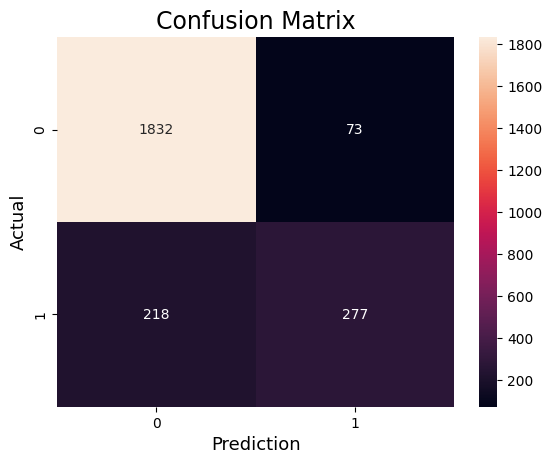

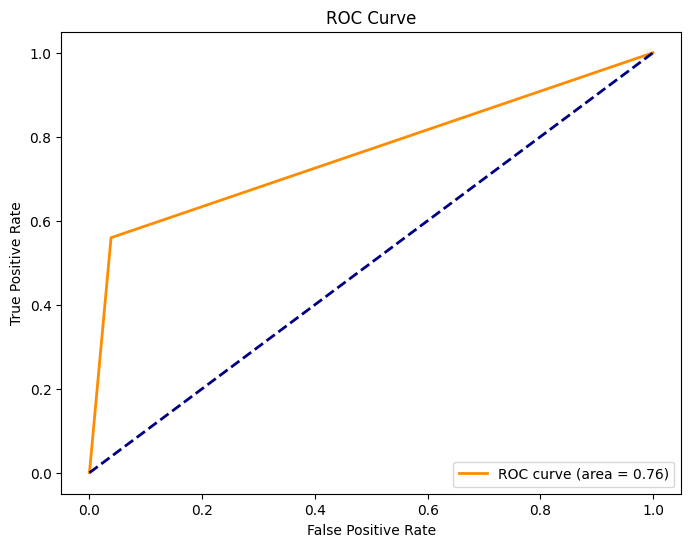

[LightGBM] [Warning] Unknown parameter: feature_freaction
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Unknown parameter: feature_freaction
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Cur

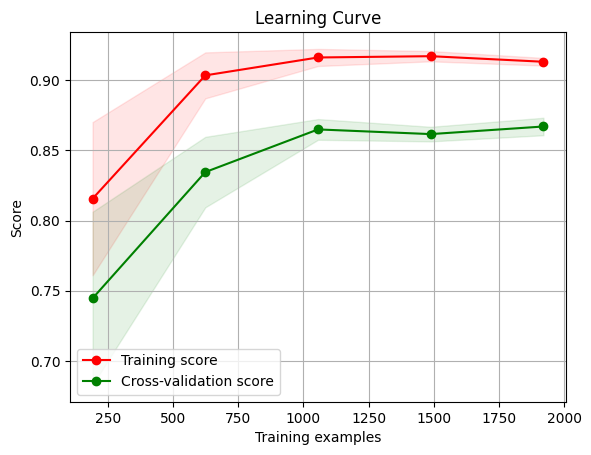

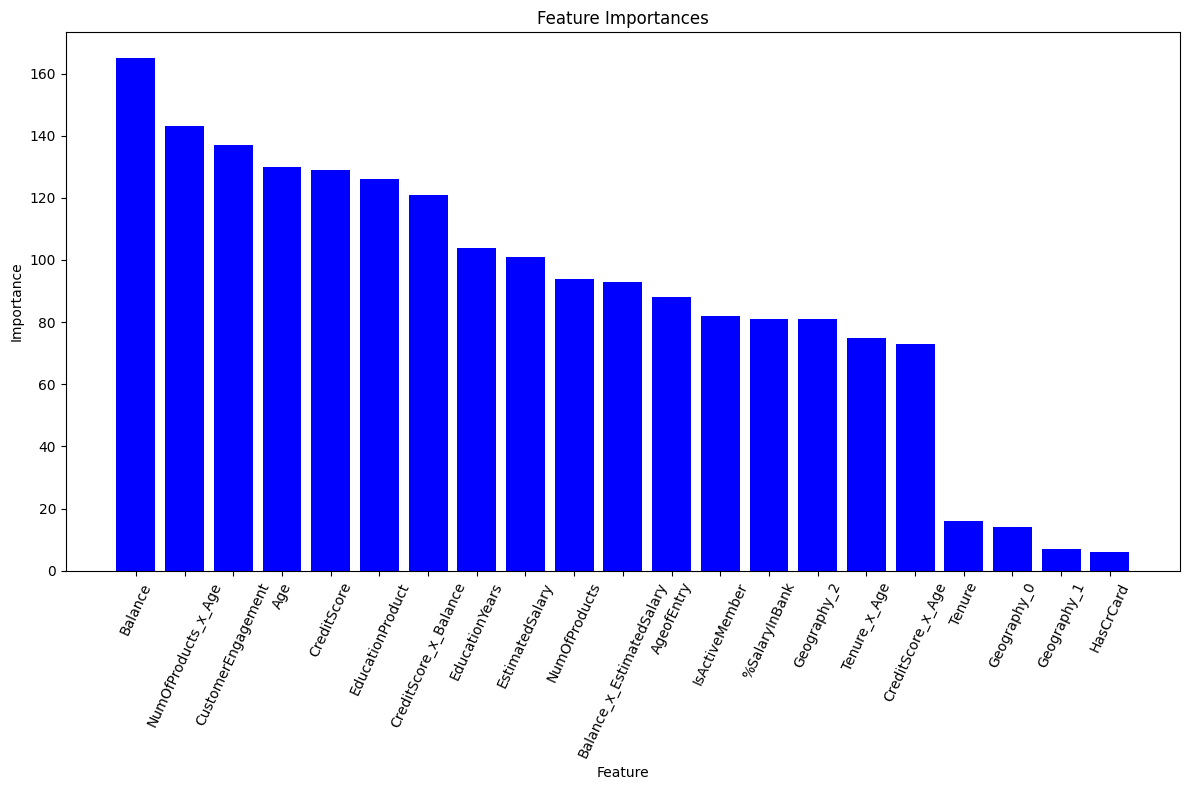

In [21]:
train.dropna(inplace=True)
X_train, X_val, y_train, y_val = train_test_split(train.drop(['Exited','Id'],axis=1), train.Exited, test_size=0.3,random_state=42)

# Encoders 
encoder = CountFrequencyEncoder(
encoding_method='frequency',
variables=['Geography'],
)

encoder2 = OrdinalEncoder(
    encoding_method='ordered',
    variables=['Geography'],
    ignore_format=True)

# Scaler
ss=StandardScaler()

# Feature engineering X_train
X_train=new_variables(X_train)
X_train=encoder.fit_transform(X_train)
X_train=encoder2.fit_transform(X_train,y_train)
X_train=encoding(X_train)
X_train.drop(['Gender'],axis=1,inplace=True)
X_train_scaled=ss.fit_transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled,columns=X_train.columns)

#Modelo
# param_grid = {
# 'boosting_type':['dart','gbdt'],
# 'num_leaves': [20,30,40],
# 'learning_rate': [0.1,0.01,0.001],
# 'n_estimators': [100,200,500],
# 'max_depth': [10,20,30]}


#Modelo
clf = lgb.LGBMClassifier(
                        boosting_type='dart',
                        num_leaves=20,
                        learning_rate=0.1,
                        max_depth=10,
                        n_estimators=100,
                        objective='binary',
                        metric='binary_logloss',
                        feature_freaction=0.8,
                        bagging_fraction=0.6,
                        bagging_freq=10,
                        lambda_l1=1,
                        lambda_l2=1,
                        min_data_in_leaf=20,
                        min_gain_to_split=0.1)

skf=StratifiedKFold(n_splits=5,shuffle=True)
#gcv=GridSearchCV(clf,param_grid=param_grid,cv=skf,scoring='accuracy',n_jobs=-1)

# Feature Engineering X_val
X_val=new_variables(X_val)
X_val=encoder.transform(X_val)
X_val=encoder2.transform(X_val)
X_val=encoding(X_val)
X_val.drop(['Gender'],axis=1,inplace=True)
X_val_columns=X_val.columns
X_val_scaled=ss.transform(X_val)
X_val=pd.DataFrame(X_val_scaled,columns=X_val_columns)

#Fit
clf.fit(X_train_scaled, y_train)


# Predicciones
y_pred = clf.predict_proba(X_val)[:, 1]
y_pred = (y_pred > 0.49).astype(int)

# Metricas
print_metrics(y_val,y_pred,clf,X_val,skf)
plot_metrics(y_val,y_pred,clf,X_val,X_train_scaled,skf)

# Pickles
with open(f'Pickle_ipynb/model_LGBM.pkl','wb') as f:
    pickle.dump(clf,f)
    
with open(f'Pickle_ipynb/encoder.pkl','wb') as f:
    pickle.dump(encoder,f)
    
with open(f'Pickle_ipynb/encoder2.pkl','wb') as f:
    pickle.dump(encoder2,f)
    
with open(f'Pickle_ipynb/scaler.pkl','wb') as f:
    pickle.dump(ss,f)
        


In [11]:
clf.get_params()

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 20,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'binary_logloss',
 'feature_freaction': 0.8,
 'bagging_fraction': 0.6,
 'bagging_freq': 10,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'min_data_in_leaf': 20,
 'min_gain_to_split': 0.1}